In [1]:
import requests
import cv2
import numpy as np
import json
import ast
from bs4 import BeautifulSoup

!pip install cupy-cuda101
import cupy

In [2]:
def get_synset_api():
  synset_path = 'https://firebasestorage.googleapis.com/v0/b/nami-5a921.appspot.com/o/synset.json?alt=media&token=70ba0c72-24e2-4cb1-b379-0a332892eb78'
  with requests.Session() as req:
    resp = req.get(synset_path)
    dict_nounid = ast.literal_eval(resp.content.decode('utf-8'))
    return dict_nounid

In [3]:
def get_synset_gdrive(synset_path):
  synset_path = '/content/drive/My Drive/synset.json'
  with open(synset_path) as file:
    dict_nounid = json.load(file)
    return dict_nounid

dict_nounid = get_synset_gdrive('/content/drive/My Drive/synset.json')

In [4]:
def get_nounids(noun):
  return dict_nounid[noun]
get_nounids('cat')

['n02121620', 'n02127808', 'n02983507', 'n02985606', 'n10153414']

In [5]:
import time
def get_dataset(noun, dimension=(224,224), max=None, timeout=0.5, save_to=None):
  try:
    noun_ids = get_nounids(noun)
  except KeyError:
   raise KeyError("Error",noun,"is not in the synset or maybe unavaliable...")
   return
 
  correct = 0

  dataset = cupy.asarray([])

  for noun_id in noun_ids:
    now = time.time()
    small_dataset = cupy.asarray([])
    image_url = "http://www.image-net.org/api/text/imagenet.synset.geturls?wnid="+str(noun_id)
    try:
      with requests.Session() as req:
        page = req.get(image_url)
    except TimeoutError:
      None

    print('time =',time.time()-now)
    soup = str(BeautifulSoup(page.content, 'html.parser'))
    split_url = soup.split()

    length = len(split_url)
    mod = length/10
    for i in range(length):
      
      # use `try` because some requested url are not avaliable
  
      try:
        with requests.Session() as req:
          resp = req.get(split_url[i],timeout=timeout)
        image = np.asarray(bytearray(resp.content), dtype='uint8')
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        image = cv2.resize(image, dsize=dimension)
        image_cupy = cupy.asarray(image)
        image_cupy = cupy.expand_dims(image_cupy, axis=0)

        correct += 1

        if small_dataset.shape[0] == 0:
          small_dataset = cupy.asarray(image_cupy)
        else :
          small_dataset = cupy.concatenate((small_dataset,image_cupy), axis=0)      
        
      except:
        None
        
      if i%mod == 0:
        print(i+1,'urls from',length)
        print(correct,'images have been generated...')

      if max != None and dataset.shape[0]+small_dataset.shape[0] == max:
          break

    if noun_id == noun_ids[0]:
      dataset = cupy.asarray(small_dataset)
    else:
      dataset = cupy.concatenate((dataset, small_dataset), axis=0)

    if max != None and dataset.shape[0] == max:
      break
  
  print('load',dataset.shape[0],'images dataset of',noun,'successful...')
  dataset = cupy.asnumpy(dataset)
  if save_to != None:
    np.save(save_to, dataset)
  
  return dataset


In [6]:
dataset = get_dataset('cat',(224,224),200,0.5,'/content/drive/My Drive/cat_dataset.npy')

time = 20.667184591293335
1 urls from 1485
1 images have been generated...
(1, 224, 224, 3)
298 urls from 1485
182 images have been generated...
(182, 224, 224, 3)
(200, 224, 224, 3) (200, 224, 224, 3)
load 200 images dataset of cat successful...


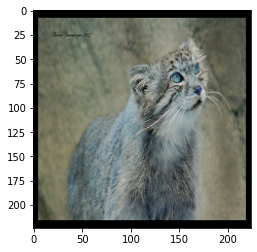

In [7]:
import matplotlib.pyplot as plt
plt.imshow(dataset[0])